In [1]:
# Importing dependencies
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
# Is gpu available?
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


In [3]:
# getting dataset ready...
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import os
root_dir = "data/"
batch_size=120
num_workers = 6

try:
    os.mkdir(root_dir)
except FileExistsError:
    print("Path already exist")

# Transform
transform = transforms.Compose([transforms.Scale(64),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                               ])

# Loading data
train_data = MNIST(root=root_dir, train=True, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

classes = [str(i) for i in range(10)]

print("Num Samples:", len(train_data))

print("Image shape:", iter(train_loader).next()[0].shape)

Path already exist
Num Samples: 60000


/home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Image shape: torch.Size([120, 1, 64, 64])


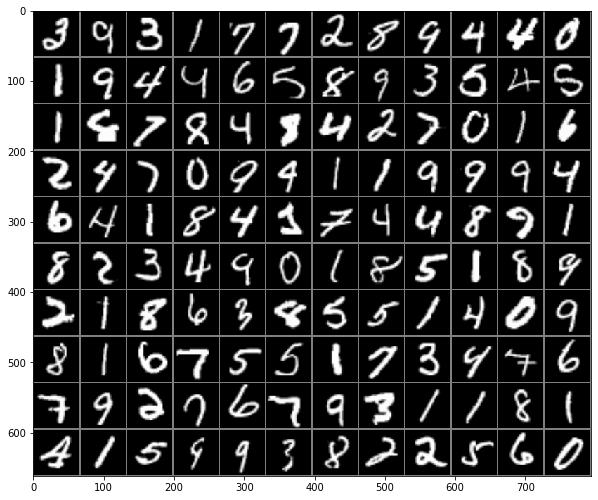

In [4]:
# Plotting Losses
def plot_losses(stats):
    D_loss = stats["D_loss"]
    G_loss = stats["G_loss"]
    epochs = list(range(1, len(D_loss)+1))
    plt.plot(epochs, D_loss)
    plt.plot(epochs, G_loss)

# Generate noise for Genarator
def generate_noise(batch_size):
    return torch.randn(batch_size, 100)
    
# showing samples...
def get_random_sample():
    data_iter = iter(train_loader)
    for i in range(np.random.randint(100)):
        next(data_iter)
    return next(data_iter)


def show_images(images, mean=0.5, stddev=0.5):
    # de-normalizing images
    images = images*stddev + mean
    img = np.array(images.tolist())
    # making numpy compatible image
    img = np.transpose(img, (1,2,0))
    plt.gcf().set_size_inches(10, 12)
    #plt.clf()
    plt.imshow(img)
    plt.show()
    #plt.draw()

images, lables = get_random_sample()
show_images(torchvision.utils.make_grid(images, 12))

In [5]:
# Defining models...

# Importing modules
import torch.nn as nn
from torch.nn.functional import relu, leaky_relu
from torch import tanh, sigmoid

# Discriminator...
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 128, 4, 2, 1),
                        nn.LeakyReLU(0.2)
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(128, 256, 4, 2, 1),
                        nn.LeakyReLU(0.2),
                        nn.BatchNorm2d(256)
                    )
        self.conv3 = nn.Sequential(
                        nn.Conv2d(256, 512, 4, 2, 1),
                        nn.LeakyReLU(0.2),
                        nn.BatchNorm2d(512)
                    )
        self.conv4 = nn.Sequential(
                        nn.Conv2d(512, 1024, 4, 2, 1),
                        nn.LeakyReLU(0.2),
                        nn.BatchNorm2d(1024)
                    )
        self.conv5 = nn.Sequential(
                        nn.Conv2d(1024, 1, 4, 1, 0),
                        nn.LeakyReLU(0.2)
                    )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x
    
    
# Generator...
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.deconv1 = nn.Sequential(
                        nn.ConvTranspose2d(100, 1024, 4, 1, 0),
                        nn.ReLU(),
                        nn.BatchNorm2d(1024)
                    )
        self.deconv2 = nn.Sequential(
                        nn.ConvTranspose2d(1024, 512, 4, 2, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(512)
                    )
        self.deconv3 = nn.Sequential(
                        nn.ConvTranspose2d(512, 256, 4, 2, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(256)
                    )
        self.deconv4 = nn.Sequential(
                        nn.ConvTranspose2d(256, 128, 4, 2, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128)
                    )
        self.deconv5 = nn.Sequential(
                        nn.ConvTranspose2d(128, 1, 4, 2, 1)
                    )
             
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = tanh(x)
        return x

In [6]:
# Initializing Descriminator and Generator...
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)
print(D)
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
)
Generator(
  (d

In [7]:
from torchsummary import summary
summary(D, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           2,176
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         524,544
         LeakyReLU-4          [-1, 256, 16, 16]               0
       BatchNorm2d-5          [-1, 256, 16, 16]             512
            Conv2d-6            [-1, 512, 8, 8]       2,097,664
         LeakyReLU-7            [-1, 512, 8, 8]               0
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
            Conv2d-9           [-1, 1024, 4, 4]       8,389,632
        LeakyReLU-10           [-1, 1024, 4, 4]               0
      BatchNorm2d-11           [-1, 1024, 4, 4]           2,048
           Conv2d-12              [-1, 1, 1, 1]          16,385
        LeakyReLU-13              [-1, 1, 1, 1]               0
Total params: 11,033,985
Trainable para

In [8]:
summary(G, input_size=(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
              ReLU-2           [-1, 1024, 4, 4]               0
       BatchNorm2d-3           [-1, 1024, 4, 4]           2,048
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
              ReLU-5            [-1, 512, 8, 8]               0
       BatchNorm2d-6            [-1, 512, 8, 8]           1,024
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
              ReLU-8          [-1, 256, 16, 16]               0
       BatchNorm2d-9          [-1, 256, 16, 16]             512
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,416
             ReLU-11          [-1, 128, 32, 32]               0
      BatchNorm2d-12          [-1, 128, 32, 32]             256
  ConvTranspose2d-13            [-1, 1, 64, 64]           2,049
Total params: 12,656,257
Trainable para

In [9]:
# Loss and Optimizer
from torch.optim import Adam

Loss = nn.BCEWithLogitsLoss()
D_opt = Adam(D.parameters(), lr=0.0002)
G_opt = Adam(G.parameters(), lr=0.0002)

# 1-Real 0-Fake
# Noisy lables for Discriminator
def D_get_lables():
    k = np.random.randint(0,9)
    if k==9:
        D_lables_real = torch.zeros(batch_size, 1).to(device)
        D_lables_fake = torch.ones(batch_size, 1).to(device)
    else:
        D_lables_real = torch.ones(batch_size, 1).to(device)
        D_lables_fake = torch.zeros(batch_size, 1).to(device)
    return D_lables_real, D_lables_fake

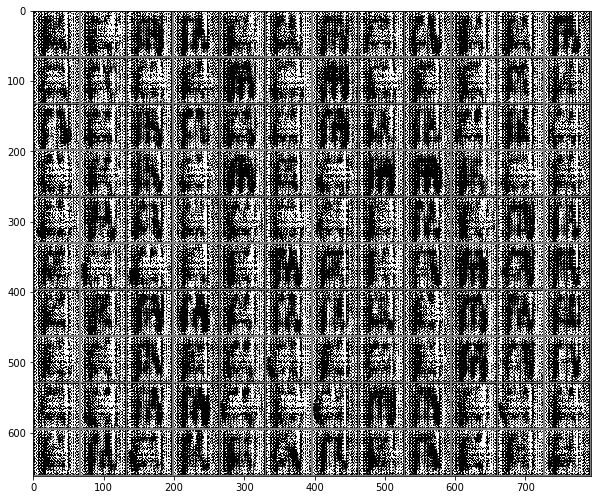

Epoch 1: D_loss: 0.08126613733138711 G_loss: 2.579027433156967


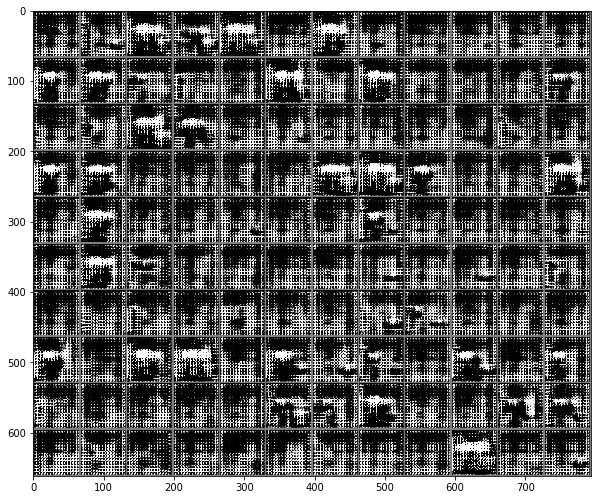

Epoch 2: D_loss: 0.2788701671435872 G_loss: 2.6430727176666258


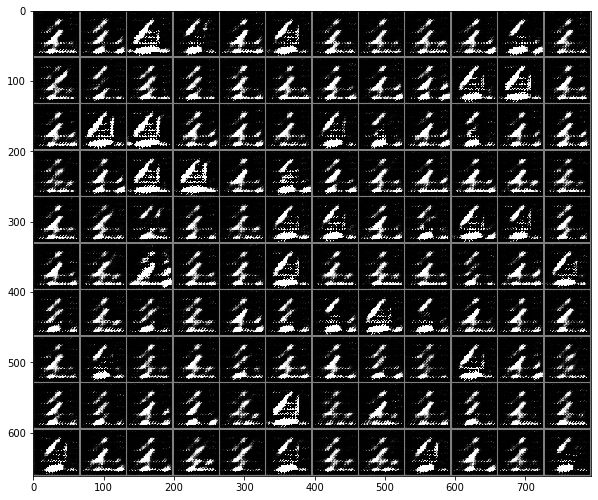

Epoch 3: D_loss: 0.04147561271377448 G_loss: 2.7548109271526338


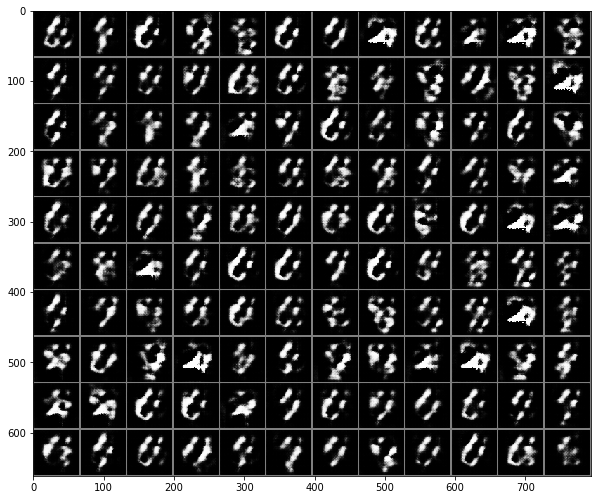

Epoch 4: D_loss: 0.1996991137541507 G_loss: 2.527845407962799


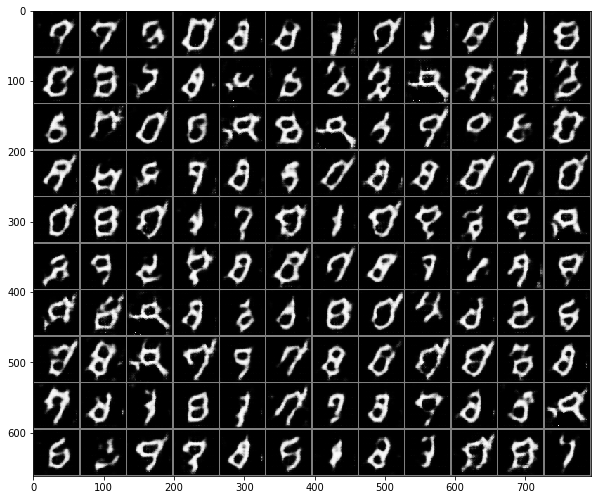

Epoch 5: D_loss: 0.26905934443980345 G_loss: 2.0517716995477677


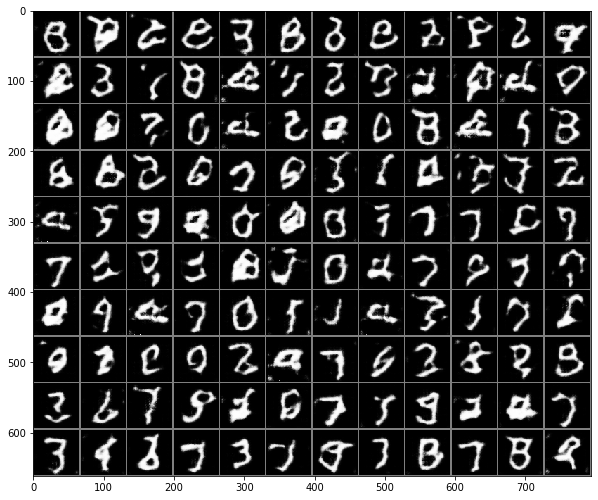

Epoch 6: D_loss: 0.2684280288282579 G_loss: 1.6620078197717667


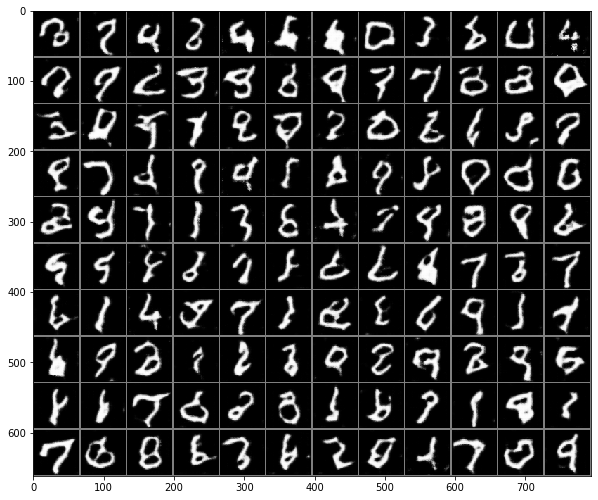

Epoch 7: D_loss: 0.29441345352516873 G_loss: 1.4333894473314286


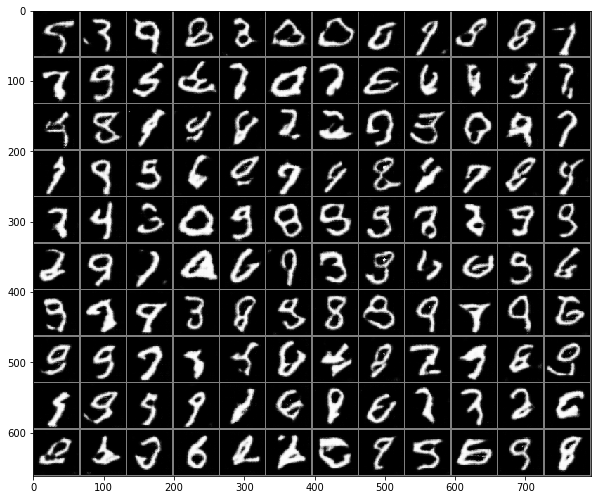

Epoch 8: D_loss: 0.3599021267528301 G_loss: 1.4574233450889587


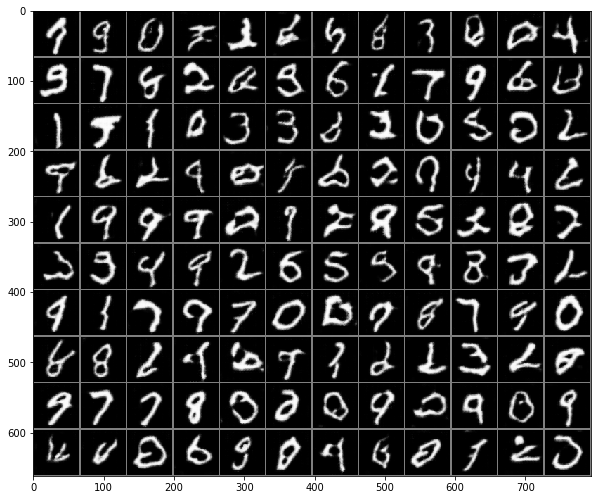

Epoch 9: D_loss: 0.35533516408242083 G_loss: 1.3877685865163802


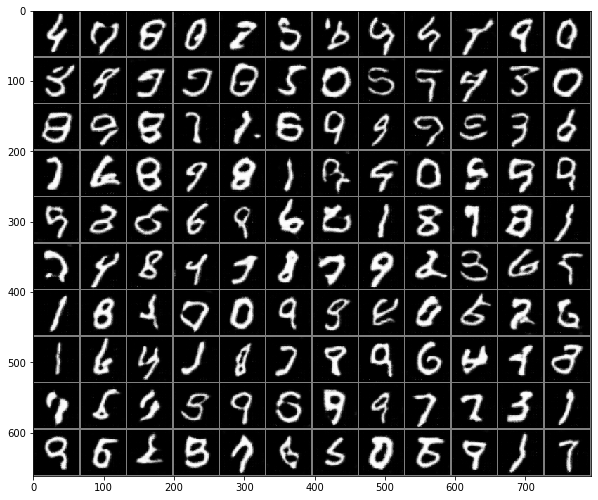

Epoch 10: D_loss: 0.3005763552109389 G_loss: 1.3106775267124176


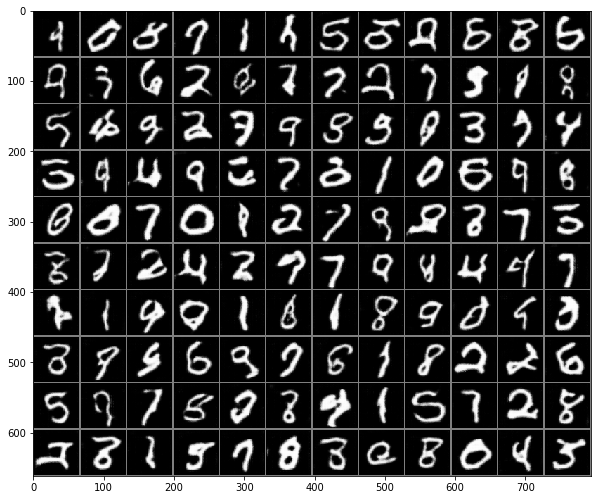

Epoch 11: D_loss: 0.39042768156487095 G_loss: 1.4054008390903472


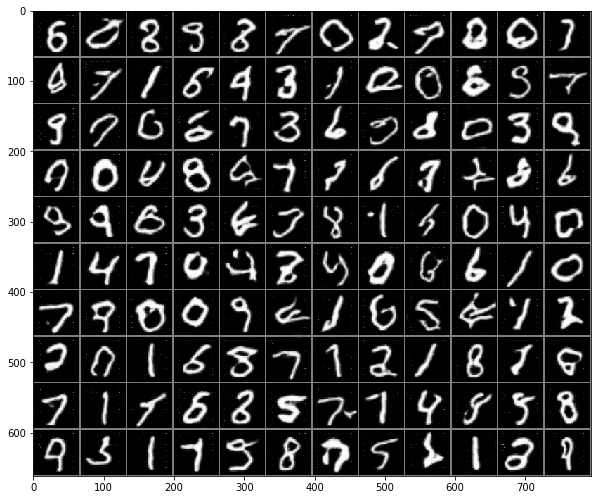

Epoch 12: D_loss: 0.38594168571697923 G_loss: 1.2575160632133484


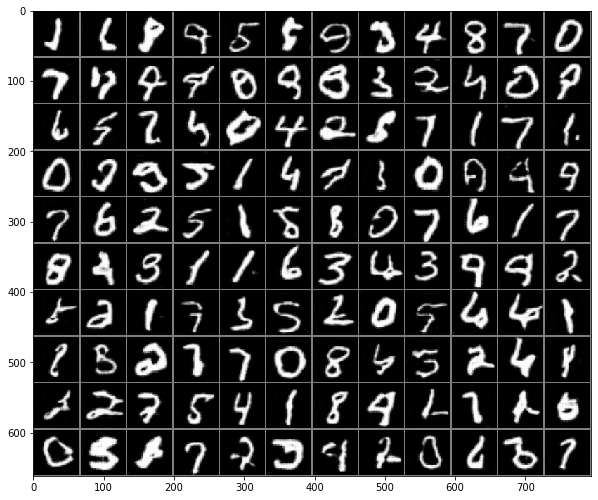

Epoch 13: D_loss: 0.33605026319986936 G_loss: 1.2985479844808578


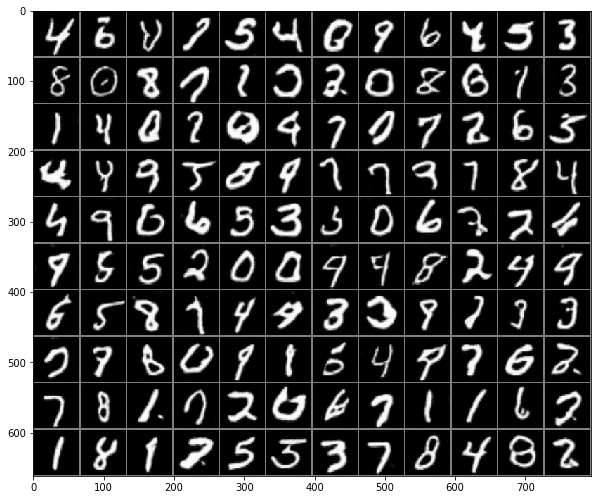

Epoch 14: D_loss: 0.304390103166536 G_loss: 1.326123671412468


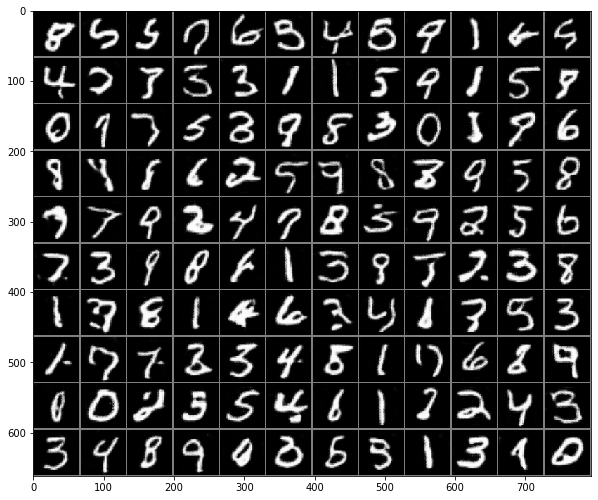

Epoch 15: D_loss: 0.3611938514746356 G_loss: 1.331115645289421


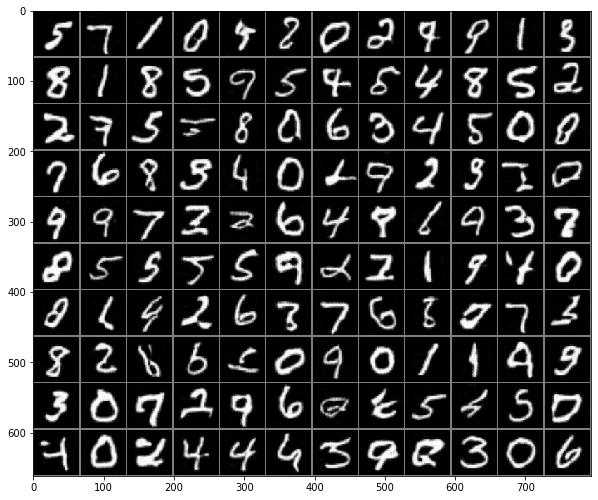

Epoch 16: D_loss: 0.41230888985569786 G_loss: 1.3439697086811067


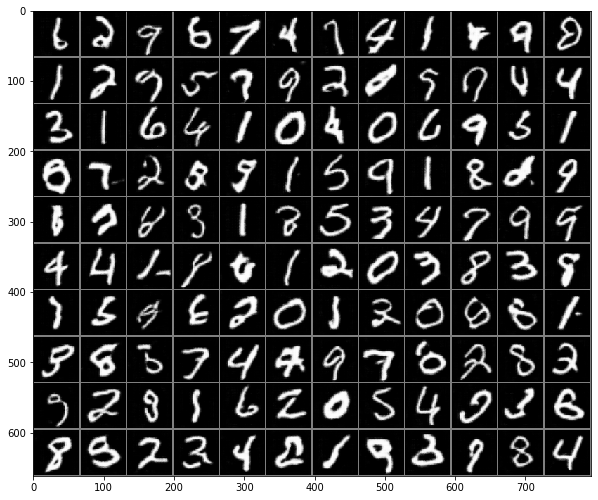

Epoch 17: D_loss: 0.41774977627120613 G_loss: 1.3961389023065567


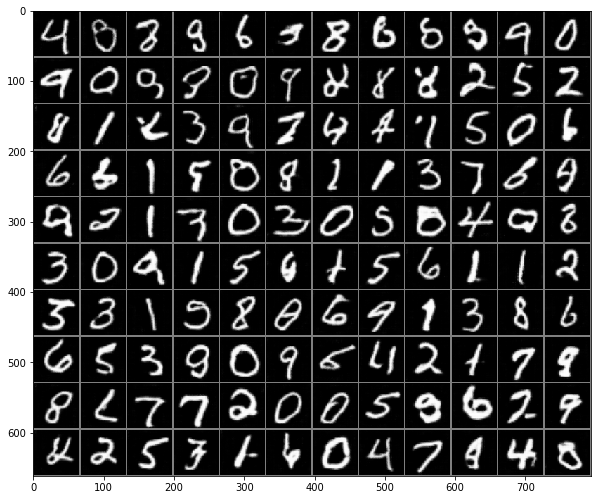

Epoch 18: D_loss: 0.399177471111739 G_loss: 1.2886753611564636


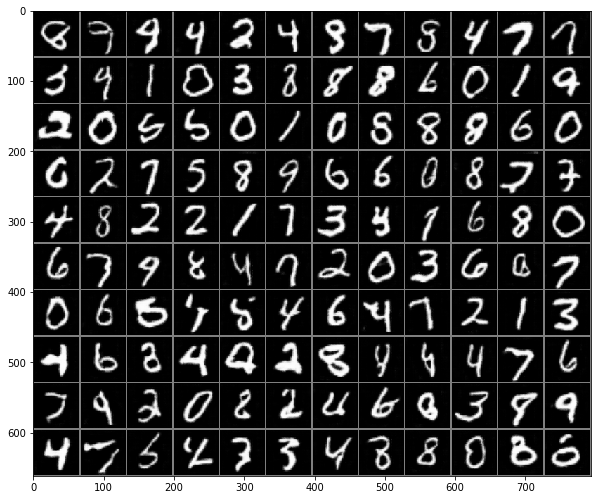

Epoch 19: D_loss: 0.3101184905540188 G_loss: 1.3562109521627426


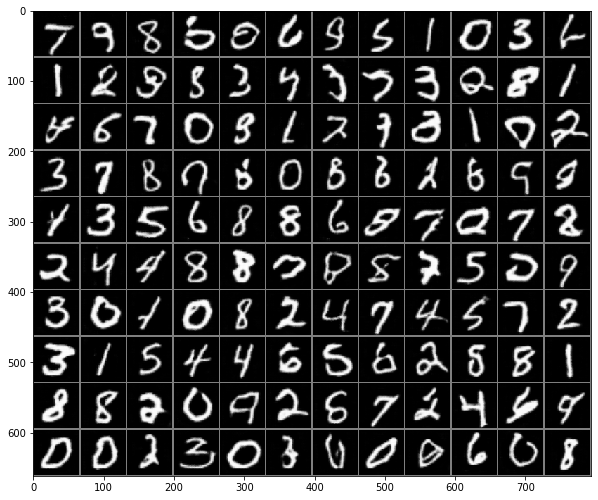

Epoch 20: D_loss: 0.322157728825246 G_loss: 1.356332403421402


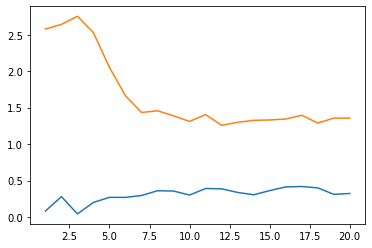

In [10]:
# Training the networks
import time
num_epochs = 20
num_batches = len(train_loader)

stats = {"D_loss":[], "G_loss":[]}
plt.ion()
for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    for i, data in enumerate(train_loader):
        
        # Training Discriminator
        D_opt.zero_grad()
        
        real_images, _ = data
        real_images = real_images.to(device)
        D_real = D(real_images).to(device)
        
        noise = generate_noise(batch_size).view(-1, 100, 1, 1).to(device)
        fake_images = G(noise).to(device)
        D_fake = D(fake_images).to(device)
        
        lables_real, lables_fake = D_get_lables()
        D_loss_real = Loss(D_real.squeeze(), lables_real.squeeze()).to(device)
        D_loss_fake = Loss(D_fake.squeeze(), lables_fake.squeeze()).to(device)
        D_loss_real.backward()
        D_loss_fake.backward()
        D_opt.step()
        
        D_running_loss += D_loss_real.item() + D_loss_fake.item()
        
        # Training Generator
        G_opt.zero_grad()
        
        noise = generate_noise(batch_size).view(-1, 100, 1, 1).to(device)
        fake_images = G(noise).to(device)
        D_fake = D(fake_images).to(device)
        
        # Lable smoothing for Generator
        lables_real = torch.randint(70,130,(batch_size,1)).to(device)/100
        G_loss = Loss(D_fake.squeeze(), lables_real.squeeze().float()).to(device)
        G_loss.backward()
        G_opt.step()
        
        G_running_loss += G_loss.item()
        
    # Showing Generated images 
    show_images(torchvision.utils.make_grid(fake_images.view(batch_size, 1, 64, 64), nrow=12))
    print("Epoch {}: D_loss: {} G_loss: {}".format(epoch+1, D_running_loss/num_batches, G_running_loss/num_batches))
    # Updating stats
    stats["D_loss"].append(D_running_loss/num_batches)
    stats["G_loss"].append(G_running_loss/num_batches)

%matplotlib inline   
plot_losses(stats)    